<a href="https://colab.research.google.com/github/achuar0818/Lung-Cancer-Detection/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.3 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory = r'/content/drive/MyDrive/Project'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

# New Section

In [ ]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

<ipython-input-4-3269ec0e3dbe>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '404 x 511': 1,
  '512 x 801': 28,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


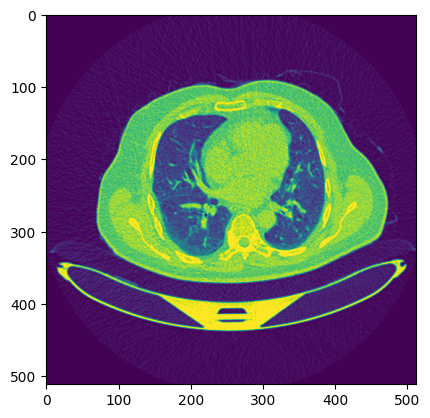

Malignant cases


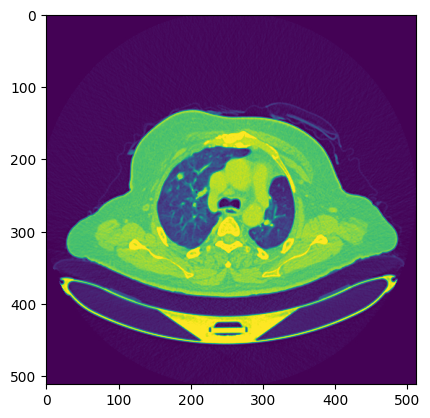

Normal cases


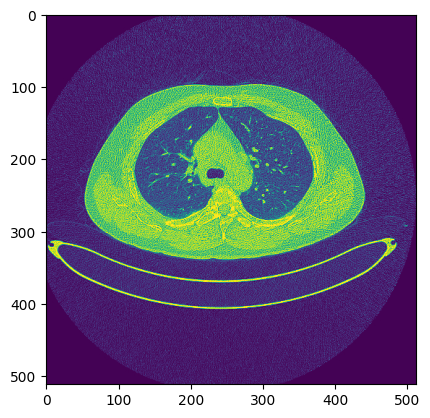

In [ ]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

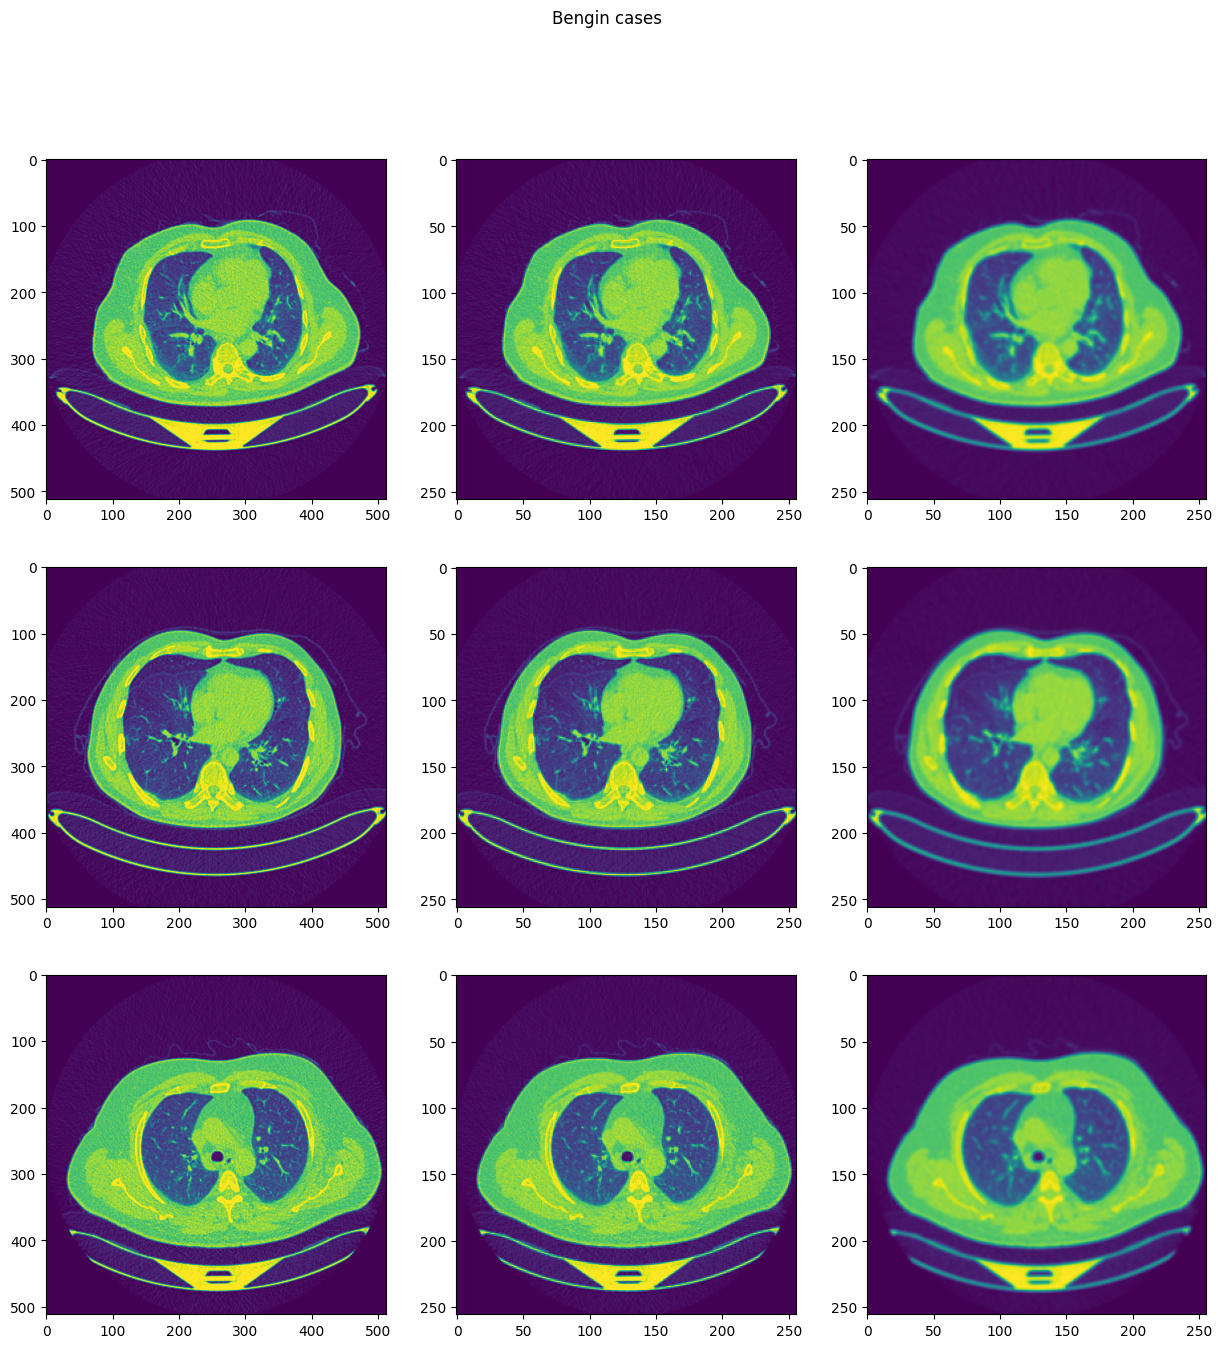

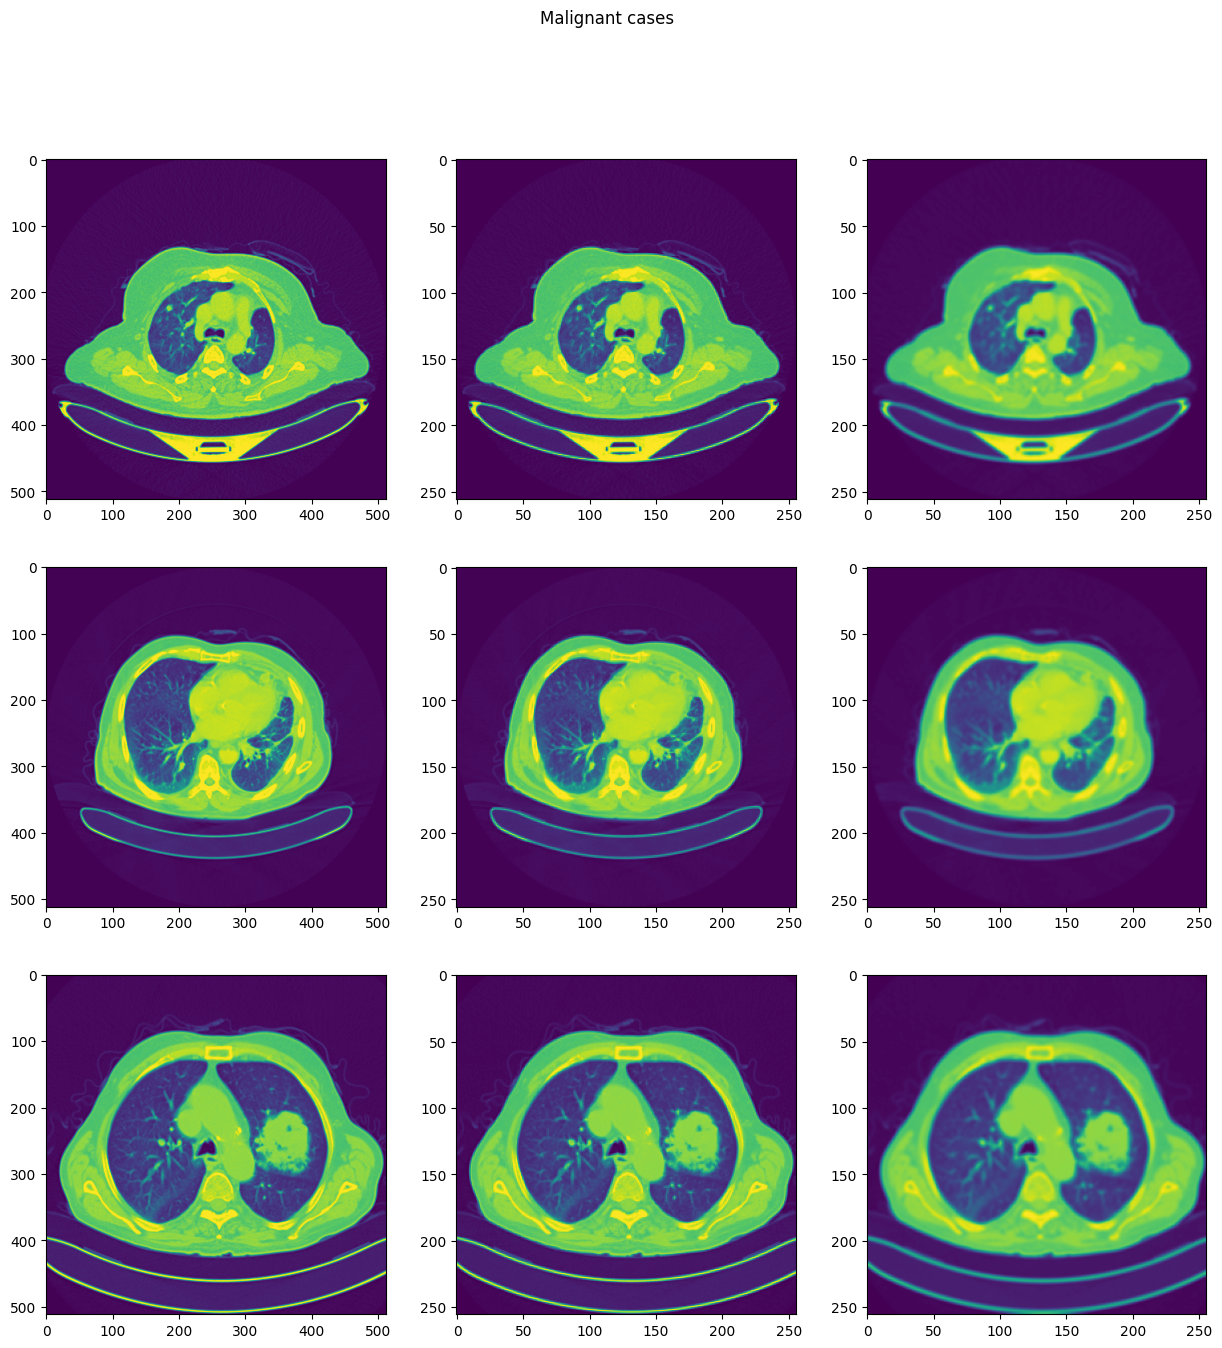

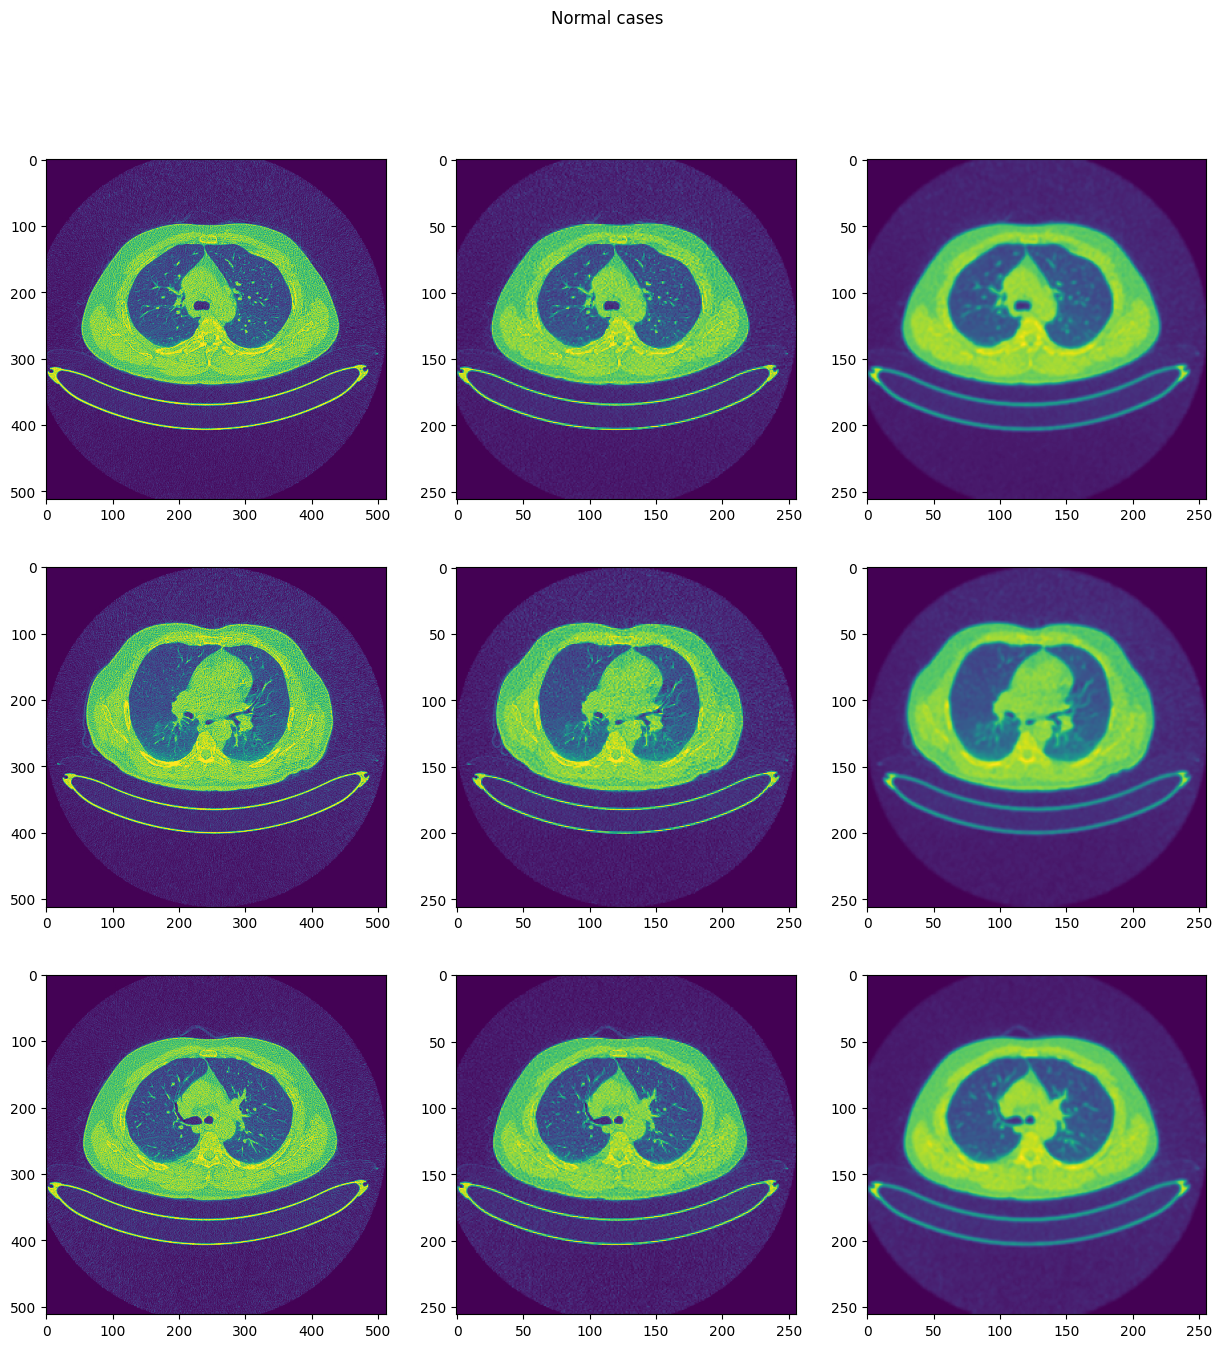

In [ ]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()


In [ ]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


In [ ]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [ ]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [ ]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


In [ ]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [ ]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
158/158 [==============================] - 9s 29ms/step - loss: 0.4631 - accuracy: 0.8444 - val_loss: 0.0644 - val_accuracy: 0.9818
Epoch 2/50
158/158 [==============================] - 3s 21ms/step - loss: 0.0426 - accuracy: 0.9913 - val_loss: 0.0819 - val_accuracy: 0.9782
Epoch 3/50
158/158 [==============================] - 3s 21ms/step - loss: 0.0269 - accuracy: 0.9937 - val_loss: 0.0230 - val_accuracy: 0.9927
Epoch 4/50
158/158 [==============================] - 3s 21ms/step - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.0248 - val_accuracy: 0.9964
Epoch 5/50
158/158 [==============================] - 3s 22ms/step - loss: 0.0384 - accuracy: 0.9937 - val_loss: 0.0180 - val_accuracy: 0.9964
Epoch 6/50
158/158 [==============================] - 4s 22ms/step - loss: 0.0170 - accuracy: 0.9960 - val_loss: 0.0397 - val_accuracy: 0.9964
Epoch 7/50
158/158 [==============================] - 4s 23ms/step - loss: 0.0066 - accuracy: 0.9968 - val_loss: 0.0066 - val_accuracy: 0.9964

In [ ]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 8s 61ms/step
              precision    recall  f1-score   support

           0       0.13      0.87      0.22        30
           1       0.72      0.20      0.31       141
           2       0.38      0.12      0.19       104

    accuracy                           0.24       275
   macro avg       0.41      0.40      0.24       275
weighted avg       0.53      0.24      0.26       275

[[26  2  2]
 [94 28 19]
 [82  9 13]]


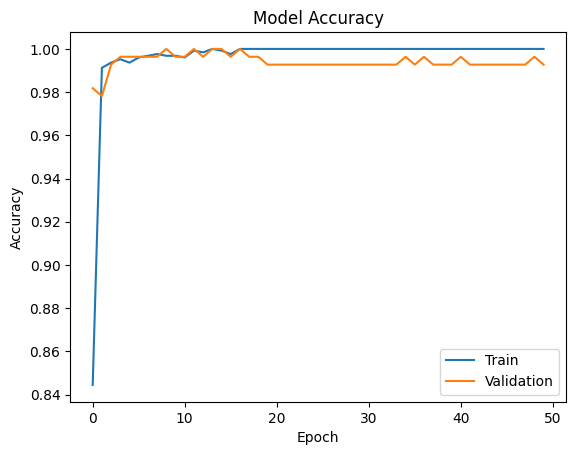

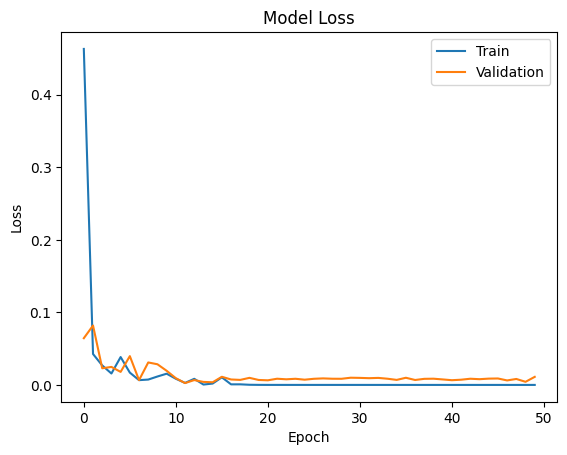

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
model1.save('model.h5')

In [ ]:
import pickle
import tensorflow as tf

# Load the Keras model from the .h5 file
model = tf.keras.models.load_model('model.h5')

# Convert the Keras model to a pickle object
model_pickle = pickle.dumps(model)

# Save the pickle object to a file
with open('my_model.pickle', 'wb') as f:
    f.write(model_pickle)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np


In [ ]:
# Load the image using OpenCV
image_path = input("Enter path to image: ")
img = cv2.imread(image_path , 0)

# Preprocess the image
img = cv2.resize(img, (img_size, img_size))
img = img / 255.0
img = np.array(img).reshape(-1, img_size, img_size, 1)

# Obtain the prediction from the model
prediction = model1.predict(img)

# Interpret the prediction
class_label = np.argmax(prediction)
print('According to the scan image provided the case is', categories[class_label])


Enter path to image: /content/drive/MyDrive/Project/Bengin cases/Bengin case (106).jpg
1/1 [==============================] - 0s 113ms/step
According to the scan image provided the case is Bengin cases
